The datasets `ADNI1_Complete_3Yr_1.5T` and `ADNI1_Complete_3Yr_3T` have been selected for the project but they contain some duplicate subjects between them so we need to inspect them to decide how to proceed. We will:
- Check if the `nii` files are duplicates for the same subject (compare dates, IDs and descriptions)
- Decide which files to keep

### Load the data

In [1]:
import pandas as pd
from get_config import get_config_dict

# Load the config
config = get_config_dict()

df3t = pd.read_csv(r'~/ADNI_data/ADNI1_Complete_3Yr_3T_4_08_2024.csv')
df15t = pd.read_csv(r'~/ADNI_data/ADNI1_Complete_3Yr_1.5T_4_08_2024.csv')

print("Shape of 3T data", df3t.shape)
print("Shape of 1.5T data", df15t.shape)

Shape of 3T data (347, 12)
Shape of 1.5T data (1693, 12)


Drop unneccessary columns

In [2]:
df3t.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I119733,136_S_0429,MCI,M,63,bl,MRI,MPR; ; N3; Scaled_2,Processed,6/27/2006,NiFTI,NaN
1,I88169,136_S_0429,MCI,M,64,m18,MRI,MPR; ; N3; Scaled,Processed,12/17/2007,NiFTI,NaN
2,I66801,136_S_0429,MCI,M,63,m06,MRI,MPR; ; N3; Scaled,Processed,12/18/2006,NiFTI,NaN
3,I205562,136_S_0429,MCI,M,66,m36,MRI,MPR; ; N3; Scaled,Processed,7/13/2009,NiFTI,NaN
4,I83549,136_S_0429,MCI,M,64,m12,MRI,MPR; ; N3; Scaled,Processed,6/18/2007,NiFTI,NaN


In [3]:
df15t.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I204843,941_S_1202,CN,M,81,m36,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/14/2010,NiFTI,NaN
1,I137298,941_S_1202,CN,M,80,m24,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/17/2009,NiFTI,NaN
2,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
3,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN
4,I75141,941_S_1194,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/22/2007,NiFTI,NaN


### Keep only the corresponding 1.5T data we have

In [4]:
import os
from pathlib import Path

print('Before filtering')
print('Number of 1.5T images:', df15t['Image Data ID'].nunique())
print('Number of 1.5T subjects:', df15t.Subject.nunique())

raw_data_dir = r'/home/nacer/ADNI_data/ADNI1_Complete_3Yr/raw_data'
existing_image_ids = []
for folder, dirs, filenames in os.walk(Path(raw_data_dir)):
    dirname = Path(folder).name
    if dirname.startswith('I'):
        existing_image_ids.append(dirname)

df15t = df15t[df15t['Image Data ID'].isin(existing_image_ids)]

print('\nAfter filtering')
print('Number of 1.5T images:', df15t['Image Data ID'].nunique())
print('Number of 1.5T subjects:', df15t.Subject.nunique())

Before filtering
Number of 1.5T images: 1693
Number of 1.5T subjects: 382



After filtering
Number of 1.5T images: 339
Number of 1.5T subjects: 226


### Drop unneccessary columns

In [5]:
cols_to_drop = ['Modality', 'Downloaded', 'Type', 'Format']#, 'Sex', 'Age']
df3t.drop(columns=cols_to_drop, inplace=True)
df15t.drop(columns=cols_to_drop, inplace=True)

print("Shape of 3T data", df3t.shape)
print("Shape of 1.5T data", df15t.shape)

Shape of 3T data (347, 8)
Shape of 1.5T data (339, 8)


### Concatenate the dataframes

In [6]:
df15t['T'] = '1.5T'
df3t['T'] = '3T'
df = pd.concat([df15t, df3t]).sort_values(['Subject', 'Acq Date'])
df['Acq Date'] = pd.to_datetime(df['Acq Date'])

print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())
print('Shape: ', df.shape)

Number of images: 686
Number of subjects: 256
Shape:  (686, 9)


### The checks

#### Check duplicate images

Check if the scans that have the same date also have the same image id and compare the descriptions

In [7]:
df[df.duplicated('Image Data ID')]

,Image Data ID,Subject,Group,Sex,Age,Visit,Description,Acq Date,T


Every image has a unique ID. So we should inspect the descriptions

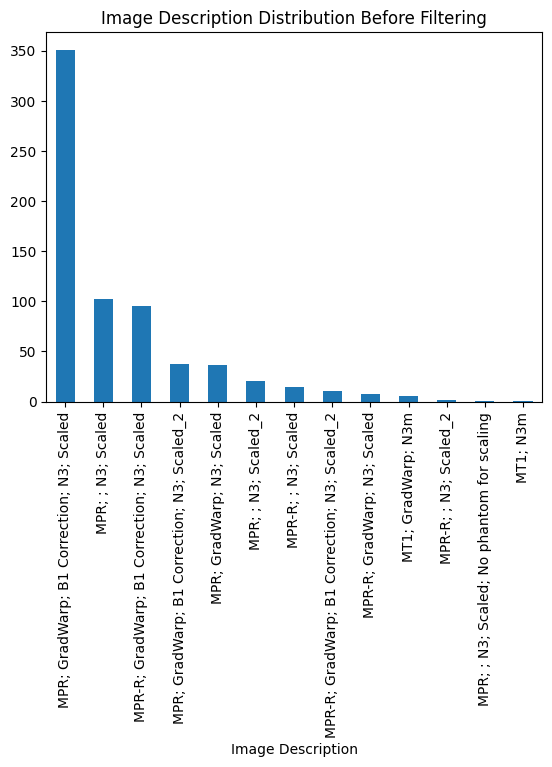

In [8]:
import matplotlib.pyplot as plt

df.Description.value_counts().plot(kind='bar')
plt.xlabel('Image Description')
plt.title('Image Description Distribution Before Filtering')
plt.show()

- There are some duplicated descriptions (ending with **_2**) as well as **non MPR** descriptions
- These need to be dropped so that we have a minimum level of consistency among the descriptions

In [9]:
# Drop the images with descriptions ending with '2' as well as non 'MPR' or 'MPR-R' ones
descripions_to_drop_mask = df['Description'].str.endswith('2') | (~df['Description'].str.startswith('MPR'))
# descripions_to_drop_mask = (~df['Description'].str.startswith('MPR'))
print('Number of images dropped: ', descripions_to_drop_mask.sum())
df = df[~descripions_to_drop_mask]

Number of images dropped:  78


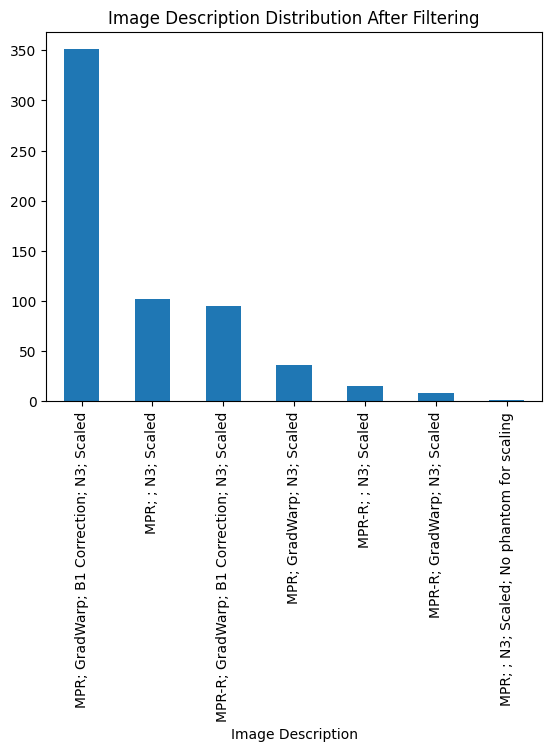

In [10]:
df.Description.value_counts().plot(kind='bar')
plt.xlabel('Image Description')
plt.title('Image Description Distribution After Filtering')
plt.show()

In [11]:
print('Shape:', df.shape)
print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())

Shape: (608, 9)
Number of images: 608
Number of subjects: 243


#### Check the image counts

In [12]:
# Number of images per subject by magnetic field strength (T)
image_counts_per_subject_by_T = df.pivot_table(values='Image Data ID', index='Subject', aggfunc='count', columns='T')
image_counts_per_subject_by_T.describe().convert_dtypes()

T,1.5T,3T
count,212.0,60.0
mean,1.476415,4.916667
std,0.67058,0.907439
min,1.0,3.0
25%,1.0,4.0
50%,1.0,5.0
75%,2.0,6.0
max,4.0,6.0


In [13]:
# Number of images per subject by visit
image_counts_per_subject_by_visit = df.pivot_table(
    index='Subject',
    columns='Visit',
    values='Image Data ID',
    aggfunc='count',
    fill_value=0
)
image_counts_per_subject_by_visit.describe().convert_dtypes()

Visit,bl,m06,m12,m18,m24,m36
count,243.0,243.0,243.0,243.0,243.0,243.0
mean,0.238683,0.580247,0.530864,0.213992,0.559671,0.378601
std,0.427158,0.579203,0.547415,0.458494,0.574545,0.526837
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,1.0,1.0,0.0,1.0,0.0
75%,0.0,1.0,1.0,0.0,1.0,1.0
max,1.0,2.0,2.0,2.0,2.0,2.0


In [14]:
num_duplicated_visits = df.duplicated(['Subject', 'Visit']).sum()
print(f'There are {num_duplicated_visits} total duplicate combinations of subjects and visits')
num_duplicated_visits = df.duplicated(['Subject', 'Acq Date']).sum()
print(f'There are {num_duplicated_visits} total duplicate combinations of subjects and dates')

There are 37 total duplicate combinations of subjects and visits
There are 26 total duplicate combinations of subjects and dates


- Some subjects have duplicated visits with the images having same or different dates in those visits
- Only same-day images are going to be considered as duplicated
- One way to address this is by keeping only the image that went through more standardization steps (longer description)

In [15]:
# Sort the duplicated visit images by description (longer description goes to the bottom)
df = df.sort_values(['Subject', 'Visit', 'Acq Date', 'Description'])
# Set the index for a clearer view of the hierarchy
df[df.duplicated(['Subject', 'Visit', 'Acq Date'], keep=False)]\
  .set_index(["Subject", "Visit", "Acq Date", "Group"])\
  .head(30)

Image Data ID Sex  Age  \
Subject    Visit Acq Date   Group                          
002_S_0413 m24   2008-07-31 CN          I120746   F   79   
                            CN          I120917   F   79   
005_S_0324 m36   2009-06-01 MCI         I150214   F   79   
                            MCI         I150219   F   79   
005_S_0553 m36   2009-09-15 CN          I162016   M   88   
                            CN          I161997   M   88   
023_S_0058 m36   2008-12-09 CN          I132341   M   73   
                            CN          I132350   M   73   
023_S_0061 m24   2007-12-13 CN           I87055   F   79   
                            CN           I87064   F   79   
023_S_0331 m18   2007-10-09 MCI          I79550   F   66   
                            MCI          I89738   F   66   
023_S_0388 m18   2007-10-30 MCI          I81910   M   73   
                            MCI          I81919   M   73   
023_S_0604 m24   2008-07-30 MCI         I123861   M   89   
                            MCI         I120798   M   89   
023_S_0625 m06   2007-02-27 MCI         I101445   M   77   
                            MCI          I52098   M   77   
023_S_0916 m24   2008-09-30 AD          I124083   M   82   
                            AD          I124097   M   82   
023_S_1046 m18   2008-05-30 MCI         I109492   M   73   
                            MCI         I109497   M   73   
023_S_1262 m06   2007-09-04 AD           I76649   F   73   
                            AD           I77044   F   73   
027_S_0307 m24   2008-04-16 MCI         I103672   M   81   
                            MCI         I103681   M   81   
032_S_1169 m06   2007-08-24 CN           I75042   F   73   
                            CN           I78930   F   73   
           m12   2008-01-17 CN           I96300   F   73   
                            CN           I94476   F   73   

                                                                  Description  \
Subject    Visit Acq Date   Group                                               
002_S_0413 m24   2008-07-31 CN                              MPR; ; N3; Scaled   
                            CN       MPR; GradWarp; B1 Correction; N3; Scaled   
005_S_0324 m36   2009-06-01 MCI    MPR-R; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
005_S_0553 m36   2009-09-15 CN     MPR-R; GradWarp; B1 Correction; N3; Scaled   
                            CN       MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0058 m36   2008-12-09 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
                            CN       MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0061 m24   2007-12-13 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
                            CN       MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0331 m18   2007-10-09 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0388 m18   2007-10-30 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0604 m24   2008-07-30 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0625 m06   2007-02-27 MCI    MPR-R; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_0916 m24   2008-09-30 AD       MPR; GradWarp; B1 Correction; N3; Scaled   
                            AD       MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_1046 m18   2008-05-30 MCI    MPR-R; GradWarp; B1 Correction; N3; Scaled   
                            MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
023_S_1262 m06   2007-09-04 AD       MPR; GradWarp; B1 Correction; N3; Scaled   
                            AD       MPR; GradWarp; B1 Correction; N3; Scaled   
027_S_0

In [16]:
# Drop duplicated images keeping the last one (the longer description after sorting)
df = df.drop_duplicates(["Subject", "Visit", 'Acq Date'], keep='last')
df.set_index(["Subject", "Visit", "Acq Date", "Group"]).head(30)

Image Data ID Sex  Age  \
Subject    Visit Acq Date   Group                          
002_S_0413 bl    2006-05-19 CN           I40657   F   76   
           m12   2007-06-01 CN           I64551   F   77   
           m24   2008-07-31 CN          I120917   F   79   
           m36   2009-04-30 CN          I149735   F   79   
002_S_0559 bl    2006-06-27 CN           I45126   M   79   
           m06   2006-12-12 CN           I79123   M   80   
           m12   2007-10-18 CN           I82102   M   81   
           m24   2008-08-15 CN          I120779   M   82   
           m36   2009-06-30 CN          I171087   M   82   
002_S_0729 m06   2007-02-22 MCI          I64741   F   66   
           m18   2008-04-03 MCI         I121067   F   67   
           m24   2008-09-29 MCI         I123994   F   67   
002_S_0782 m06   2007-04-11 MCI          I60456   M   82   
002_S_1018 bl    2006-12-18 AD           I40828   F   71   
           m06   2007-06-14 AD           I64750   F   71   
           m12   2007-12-07 AD           I97022   F   72   
           m24   2008-12-12 AD          I132795   F   73   
002_S_1070 bl    2006-12-18 MCI          I40840   M   74   
           m06   2007-06-07 MCI          I60050   M   74   
           m12   2007-12-10 MCI          I86231   M   75   
           m18   2008-08-13 MCI         I120784   M   75   
           m24   2008-12-11 MCI         I132215   M   76   
           m36   2009-12-10 MCI         I165284   M   77   
002_S_1261 m06   2007-08-30 CN           I79126   F   72   
           m24   2009-02-05 CN          I139510   F   73   
           m36   2010-02-25 CN          I171106   F   74   
002_S_1268 m24   2009-03-04 MCI         I143103   M   85   
002_S_1280 m06   2007-08-23 CN           I81321   F   71   
003_S_1122 m12   2008-01-30 MCI          I96010   F   78   
005_S_0221 m12   2007-03-21 AD          I102054   M   69   

                                                                  Description  \
Subject    Visit Acq Date   Group                                               
002_S_0413 bl    2006-05-19 CN                              MPR; ; N3; Scaled   
           m12   2007-06-01 CN                              MPR; ; N3; Scaled   
           m24   2008-07-31 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
           m36   2009-04-30 CN                              MPR; ; N3; Scaled   
002_S_0559 bl    2006-06-27 CN                              MPR; ; N3; Scaled   
           m06   2006-12-12 CN                              MPR; ; N3; Scaled   
           m12   2007-10-18 CN                            MPR-R; ; N3; Scaled   
           m24   2008-08-15 CN                              MPR; ; N3; Scaled   
           m36   2009-06-30 CN                              MPR; ; N3; Scaled   
002_S_0729 m06   2007-02-22 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
           m18   2008-04-03 MCI    MPR-R; GradWarp; B1 Correction; N3; Scaled   
           m24   2008-09-29 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_0782 m06   2007-04-11 MCI      MPR; GradWarp; B1 Correction; N3; Scaled   
002_S_1018 bl    2006-12-18 AD                              MPR; ; N3; Scaled   
           m06   2007-06-14 AD                              MPR; ; N3; Scaled   
           m12   2007-12-07 AD                              MPR; ; N3; Scaled   
           m24   2008-12-12 AD                              MPR; ; N3; Scaled   
002_S_1070 bl    2006-12-18 MCI                             MPR; ; N3; Scaled   
           m06   2007-06-07 MCI                           MPR-R; ; N3; Scaled   
           m12   2007-12-10 MCI                             MPR; ; N3; Scaled   
           m18   2008-08-13 MCI                             MPR; ; N3; Scaled   
           m24   2008-12-11 MCI                             MPR; ; N3; Scaled   
           m36   2009-12-10 MCI                             MPR; ; N3; Scaled   
002_S_1261 m06   2007-08-30 CN       MPR; GradWarp; B1 Correction; N3; Scaled   
       

In [17]:
df.pivot_table(
    index='Subject',
    columns='Acq Date',
    values='Image Data ID',
    aggfunc='count',
    fill_value=0
).max().max()

1

In [18]:
print('Shape:', df.shape)
print('Number of images:', df['Image Data ID'].nunique())
print('Number of subjects:', df.Subject.nunique())

Shape: (582, 9)
Number of images: 582
Number of subjects: 243


Now every subject has at most one image per date (but possibly multiple images per visit)

### Class Imbalance

Group
AD     135.0
CN     199.0
MCI    248.0
Name: Image, dtype: float64


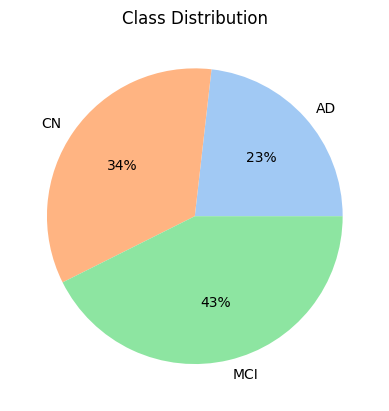

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

subject_group_pivot = df.pivot_table(values='Image Data ID', index='Subject', columns='Group', aggfunc='count')
group_counts = subject_group_pivot.sum().rename('Image')
print(group_counts)
plt.pie(group_counts, labels=group_counts.index, autopct='%.0f%%', colors=sns.color_palette('pastel'))
plt.title('Class Distribution')
plt.show()

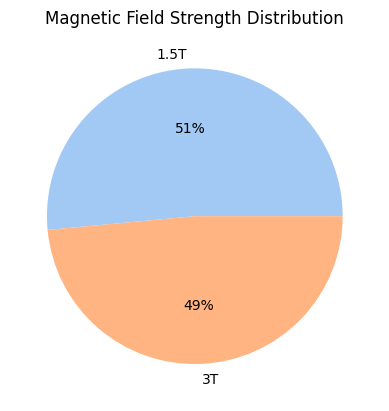

In [20]:
T_counts = image_counts_per_subject_by_T.sum()
plt.pie(T_counts, labels=T_counts.index, autopct='%.0f%%', colors=sns.color_palette('pastel'))
plt.title('Magnetic Field Strength Distribution')
plt.show()

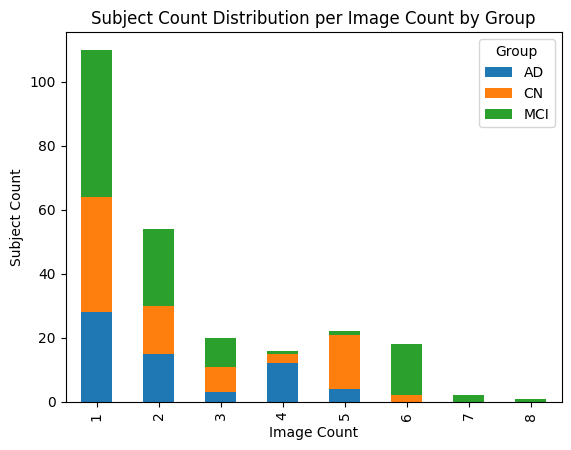

In [21]:
# Add the group column
image_counts_per_subject = df.groupby('Subject')['Image Data ID'].count().rename('Image Count').to_frame()
image_counts_per_subject = image_counts_per_subject.merge(
    df[['Subject', 'Group']].drop_duplicates().set_index('Subject'),
    left_index=True,
    right_index=True
)

# Distribution of image counts among the subjects
subject_count_per_image_count_by_group = image_counts_per_subject\
    .reset_index()\
    .pivot_table(
        index='Image Count',
        values='Subject',
        columns='Group',
        aggfunc='count',
        fill_value=0
    )
subject_count_per_image_count_by_group.plot(kind='bar', stacked=True)
plt.ylabel('Subject Count')
plt.title('Subject Count Distribution per Image Count by Group')
plt.show()

Decide on the images to select for each class to achieve class balance. This is achieved by two approaches:
- **Down sampling**: Sampling the classes with more images to have as many images as the *minimum* class 
- **Up sampling**: Sampling the classes with less images to have as many images as the *maximum* class

#### Down-sampling

In [22]:
# Number of images we need to select per group
num_images_per_group = int(group_counts.min())
num_images_per_group

135

In [23]:
import operator

# CN subjects that have 'min_images_per_subject' or more images
def filter_subjects_by_image_count(groups, cutoff, op, drop=None):
    operators = {
        '<': operator.lt,
        '<=': operator.le,
        '>': operator.gt,
        '>=': operator.ge,
        '==': operator.eq,
        '!=': operator.ne
    }
    filtered_subjects = image_counts_per_subject[
        (image_counts_per_subject.Group.isin(groups)) &
        (operators[op](image_counts_per_subject['Image Count'], cutoff))
    ]
    return filtered_subjects.drop(index=drop) if drop else filtered_subjects
    
def filter_images_by_subject_image_count(num_images_per_group, groups, min_images_per_subject=3):
    filtered_subjects = filter_subjects_by_image_count(groups=groups, cutoff=min_images_per_subject, op='>=')
    final_images = df[df.Subject.isin(filtered_subjects.index)]
    
    # choose more subjects from lower image counts to satisfy the image count per group
    current_image_count = final_images.shape[0]
    choice_history = []
    while current_image_count < num_images_per_group:
        print('current_image_count', current_image_count)
        filtered_subjects = filter_subjects_by_image_count(groups=groups, cutoff=min_images_per_subject - 1, op='==', drop=choice_history)
        print('filtered subjects count', filtered_subjects.shape[0])
        remaining_subject_count = int((num_images_per_group - current_image_count) // (min_images_per_subject - 1))
        if remaining_subject_count == 0:
            remaining_subject_count = 1
        print('remaining_subject_count', remaining_subject_count)
        choices = filtered_subjects.sample(remaining_subject_count, random_state=42).index.values
        print('choices', choices)
        choice_history.extend(choices)
        new_images = df[df.Subject.isin(choices)]
        
        if new_images.shape[0] > (num_images_per_group - current_image_count):
            new_images = new_images.sort_values(['Subject', 'Visit']).iloc[:(num_images_per_group - current_image_count)]
        
        final_images = pd.concat((final_images, new_images))
        current_image_count = final_images.shape[0]
        
    return final_images
    

final_down_sampled_cn_images = filter_images_by_subject_image_count(num_images_per_group, groups=['CN'], min_images_per_subject=3)
final_down_sampled_cn_images.shape

current_image_count 133
filtered subjects count 15
remaining_subject_count 1
choices ['094_S_0526']


(135, 9)

In [24]:
final_down_sampled_mci_images = filter_images_by_subject_image_count(num_images_per_group, groups=['MCI'], min_images_per_subject=4)
final_down_sampled_mci_images.shape

current_image_count 127
filtered subjects count 9
remaining_subject_count 2
choices ['116_S_1315' '007_S_0293']
current_image_count 133
filtered subjects count 7
remaining_subject_count 1
choices ['002_S_0729']


(135, 9)

In [25]:
final_down_sampled_ad_images = df[df.Group == 'AD']
final_down_sampled_ad_images.shape

(135, 9)

In [26]:
df_down_sampled = pd.concat([final_down_sampled_ad_images, final_down_sampled_mci_images, final_down_sampled_cn_images])
df_down_sampled.shape

(405, 9)

##### Save the final down-sampled image IDs and subject groups for preprocessing

In [27]:
if config['down_sample']:
    # Save the subject diagnosis labels for later use
    df_down_sampled[['Subject', 'Group']]\
        .drop_duplicates()\
        .set_index('Subject')\
        .to_csv('subject_groups_down_sampled.csv')

    # Save the images ids
    df_down_sampled[['Subject', 'Image Data ID', 'Group']].to_csv('final_image_ids_down_sampled.csv', index=False)

#### Up-sampling

In [28]:
# Number of images we need to select per group
num_images_per_group = int(group_counts.max())
num_images_per_group

248

In [29]:
from sklearn.utils import resample

# Imclude all the images in the minor class and resample the difference
final_up_sampled_ad_images = df[df['Group'] == 'AD']
print('Number of unique Image IDs in AD Images before resampling:', final_up_sampled_ad_images['Image Data ID'].nunique())
print('Number of unique Subjects in AD Images vefore resampling:', final_up_sampled_ad_images['Subject'].nunique())

n_samples = num_images_per_group - final_up_sampled_ad_images.shape[0]
final_up_sampled_ad_images = pd.concat([
    final_up_sampled_ad_images,
    resample(
        final_up_sampled_ad_images,
        replace=False,
        n_samples=n_samples,
        random_state=42
    )
])

print('Number of unique Image IDs in AD Images after resampling:', final_up_sampled_ad_images['Image Data ID'].nunique())
print('Number of unique Subjects in AD Images after resampling:', final_up_sampled_ad_images['Subject'].nunique())
final_up_sampled_ad_images.shape

Number of unique Image IDs in AD Images before resampling: 135
Number of unique Subjects in AD Images vefore resampling: 62
Number of unique Image IDs in AD Images after resampling: 135
Number of unique Subjects in AD Images after resampling: 62


(248, 9)

In [30]:
# Imclude all the images in the minor class and resample the difference
final_up_sampled_cn_images = df[df['Group'] == 'CN']
print('Number of unique Image IDs in CN Images before resampling:', final_up_sampled_cn_images['Image Data ID'].nunique())
print('Number of unique Subjects in CN Images vefore resampling:', final_up_sampled_cn_images['Subject'].nunique())

n_samples = num_images_per_group - final_up_sampled_cn_images.shape[0]
final_up_sampled_cn_images = pd.concat([
    final_up_sampled_cn_images,
    resample(
        final_up_sampled_cn_images,
        replace=False,
        n_samples=n_samples,
        random_state=42
    )
])

print('Number of unique Image IDs in CN Images after resampling:', final_up_sampled_cn_images['Image Data ID'].nunique())
print('Number of unique Subjects in CN Images after resampling:', final_up_sampled_cn_images['Subject'].nunique())
final_up_sampled_cn_images.shape

Number of unique Image IDs in CN Images before resampling: 199
Number of unique Subjects in CN Images vefore resampling: 81
Number of unique Image IDs in CN Images after resampling: 199
Number of unique Subjects in CN Images after resampling: 81


(248, 9)

In [31]:
final_up_sampled_mci_images = df[df['Group'] == 'MCI']
print('Number of unique Image IDs in MCI Images:', final_up_sampled_mci_images['Image Data ID'].nunique())
print('Number of unique Subjects in MCI Images:', final_up_sampled_mci_images['Subject'].nunique())

Number of unique Image IDs in MCI Images: 248
Number of unique Subjects in MCI Images: 100


In [32]:
up_sampled_df = pd.concat([
    final_up_sampled_ad_images,
    final_up_sampled_cn_images,
    final_up_sampled_mci_images
])
print('Number of unique Image IDs in final up-sampled images:', up_sampled_df['Image Data ID'].nunique())
print('Number of unique Subjects in final up-sampled images:', up_sampled_df['Subject'].nunique())
up_sampled_df.shape

Number of unique Image IDs in final up-sampled images: 582
Number of unique Subjects in final up-sampled images: 243


(744, 9)

##### Save the final up-sampled image IDs and subject groups for preprocessing

In [33]:
if config['up_sample']:
    # Save the subject diagnosis labels for later use
    up_sampled_df[['Subject', 'Group']]\
        .drop_duplicates()\
        .set_index('Subject')\
        .to_csv('subject_groups_up_sampled.csv')

    # Save the images ids
    up_sampled_df[['Subject', 'Image Data ID', 'Group']].to_csv('final_image_ids_up_sampled.csv', index=False)